<a href="https://colab.research.google.com/github/abksyed/EVA4/blob/master/S5/EVA4_S5_Assignment_iter03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Statements

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Targets

**Overall Target to Acheive**
 

1.   99.4% (this must be consistently shown in your last few epochs, and not a one-time achievement)
2.   Less than or equal to 15 Epochs
3.   Less than 10000 Parameters

*Target Acheived in Last Iteration*

1.   Parameters Used: **7624**
1.   Test Accuracy: **99.27%**
2.   Training Accuracy: **100%**
2.   Epochs Used: **15**

*Target for this Iteration:*

1.   Reduce Over-fitting
2.   Add Dropout to reduce overfitting effeciency

#Raw Data Statistics

In [0]:
#Getting to know Data
data = datasets.MNIST('./data', train= True, transform= transforms.Compose([transforms.ToTensor(),]), download= True)

exp = data.data
exp = data.transform(exp.numpy())

print('Train Statistics')
print(' - Numpy Shape:', data.data.cpu().numpy().shape)
print(' - Tensor Shape:', data.data.size())
print(' - min:', torch.min(exp))
print(' - max:', torch.max(exp))
print(' - mean:', torch.mean(exp))
print(' - std:', torch.std(exp))
print(' - var:', torch.var(exp))

Train Statistics
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


#Transforming Raw Data to Normalized Data

In [0]:
#Transforming Data (Normalizing to mean=1, std= 0)
train_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1311,), (0.3081,))
]
)

test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.1311,),(0.3081,))
])

#Creating Train/Test Split

In [0]:
#Getting Train and Test Data
train = datasets.MNIST('./data', train= True, transform= train_transform)
test = datasets.MNIST('./data', train= False, transform= test_transform)

#Dataloader Arguments & Test/Train Dataloaders

In [0]:
seed = 1

#CUDA Availability
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

#For Reproducibility
torch.manual_seed(seed)

if cuda:
    torch.cuda.manual_seed(seed)

dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory= True) if cuda else dict(shuffle= True, batch_size=64)

#Train Dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

#Test Dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: torch.Size([28, 60000, 28])
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4255)
 - max: tensor(2.8202)
 - mean: tensor(0.0004)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


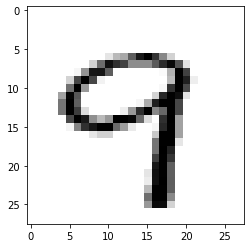

In [0]:
#Testing Normalized Data Statistics

train_numpy = train.train_data
train_numpy = train.transform(train_numpy.numpy())

print('[Train]')
print(' - Numpy Shape:', train_numpy.shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_numpy))
print(' - max:', torch.max(train_numpy))
print(' - mean:', torch.mean(train_numpy))
print(' - std:', torch.std(train_numpy))
print(' - var:', torch.var(train_numpy))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

#Viewing Sample Images in Dataset

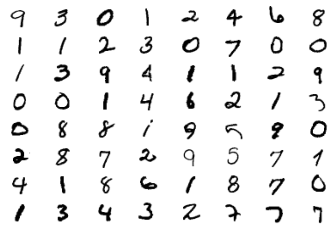

In [0]:
figure = plt.figure()
num_of_images = 64
for index in range(0, num_of_images):
    plt.subplot(8, 8, index+1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

#**THE MODEL**

In [0]:
class Net(nn.Module):

  def __init__(self):

    super(Net, self).__init__()

    #Input Block - Input= 28
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels= 1, out_channels= 8, kernel_size= 3, padding= 1, bias= False),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Dropout2d(0.1),
    ) #Output= 28 / ReceptiveField= 3

    #Convolution Block - Input= 28
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels= 8, out_channels= 8, kernel_size= 3, padding= 1, bias= False),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Dropout2d(0.1),
    ) #Output= 28 / ReceptiveField= 5

    #Max Pooling and 1x1 Convolution
    self.mp1 = nn.Sequential(
        nn.MaxPool2d(2)
    )#Output= 14 / ReceptiveField= 6

    #Convolution Block - Input= 14
    self.block3 = nn.Sequential(
        nn.Conv2d(in_channels= 8, out_channels= 12, kernel_size= 3, bias= False),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout2d(0.1), 
        #Output= 12 / ReceptiveField= 10
        nn.Conv2d(in_channels= 12, out_channels= 12, kernel_size= 3, bias= False),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout2d(0.1),
    ) #Output= 10 / ReceptiveField= 14  

    #Convolution Block - Input= 10
    self.block4 = nn.Sequential(
        nn.Conv2d(in_channels= 12, out_channels= 12, kernel_size= 3, padding= 0, bias= False),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout2d(0.1),
        #Output= 8 / ReceptiveField= 18
        nn.Conv2d(in_channels= 12, out_channels= 16, kernel_size= 3, padding= 0, bias= False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(0.1),
    ) #Output= 6 / ReceptiveField= 22
    
    #Convolution Block - Input= 6
    self.block5 = nn.Sequential(
        nn.Conv2d(in_channels= 16, out_channels= 10, kernel_size= 3, bias= False),
        nn.Dropout2d(0.1),
    ) #Output= 4 / ReceptiveField= 26

    #GAP - Input 3
    self.gap = nn.AvgPool2d(4)
    #Output= 1 / ReceptiveField= 32

  def forward(self,x):

     x = self.block1(x)
     x = self.block2(x)
     x = self.mp1(x)
     x = self.block3(x)
     x = self.block4(x)
     x = self.block5(x)
     x = self.gap(x)
     x = x.view(-1,10)

     return F.log_softmax(x, dim=-1)

#Inspecting Model Parameters

In [0]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
         Dropout2d-8            [-1, 8, 28, 28]               0
         MaxPool2d-9            [-1, 8, 14, 14]               0
           Conv2d-10           [-1, 12, 12, 12]             864
             ReLU-11           [-1, 12, 12, 12]               0
      BatchNorm2d-12           [-1, 12, 12, 12]              24
        Dropout2d-13           [-1, 12, 12, 12]               0
           Conv2d-14           [-1

#Training and Testing

In [0]:
from tqdm import tqdm

train_loss = []
test_loss = []

train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()

    y_pred = model(data)

    loss = F.nll_loss(y_pred, target)
    train_loss.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim= True)
    correct+= pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100 * correct/processed)

In [0]:
def test(model, device, test_loader):
  model.eval()
  correct= 0
  tloss= 0

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)

      output = model(data)

      tloss+= F.nll_loss(output, target, reduction= 'sum').item()
      pred= output.argmax(dim= 1, keepdim= True)
      correct+= pred.eq(target.view_as(pred)).sum().item()

  tloss /= len(test_loader.dataset)
  test_loss.append(tloss)
  print(100 * correct/len(test_loader.dataset))
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        tloss, correct, len(test_loader.dataset),
        100 * correct/len(test_loader.dataset)))
  
  test_acc.append(100 * correct/len(test_loader.dataset))

#Running the Model

In [0]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr= 0.01, momentum= 0.9)
epochs = 15

for epoch in range(epochs):
  print('EPOCH: ', epoch+1)
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH:  1


Loss=0.2173222005367279 Batch_id=937 Accuracy=85.69: 100%|██████████| 938/938 [00:14<00:00, 64.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.11

Test set: Average loss: 0.0630, Accuracy: 9811/10000 (98.11%)

EPOCH:  2


Loss=0.23130689561367035 Batch_id=937 Accuracy=92.32: 100%|██████████| 938/938 [00:13<00:00, 67.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.61

Test set: Average loss: 0.0429, Accuracy: 9861/10000 (98.61%)

EPOCH:  3


Loss=0.09803968667984009 Batch_id=937 Accuracy=92.93: 100%|██████████| 938/938 [00:13<00:00, 67.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.83

Test set: Average loss: 0.0368, Accuracy: 9883/10000 (98.83%)

EPOCH:  4


Loss=0.1260022073984146 Batch_id=937 Accuracy=93.55: 100%|██████████| 938/938 [00:14<00:00, 65.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.85

Test set: Average loss: 0.0354, Accuracy: 9885/10000 (98.85%)

EPOCH:  5


Loss=0.12266544252634048 Batch_id=937 Accuracy=93.71: 100%|██████████| 938/938 [00:14<00:00, 66.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.99

Test set: Average loss: 0.0323, Accuracy: 9899/10000 (98.99%)

EPOCH:  6


Loss=0.10161995142698288 Batch_id=937 Accuracy=93.83: 100%|██████████| 938/938 [00:14<00:00, 64.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.06

Test set: Average loss: 0.0322, Accuracy: 9906/10000 (99.06%)

EPOCH:  7


Loss=0.08006316423416138 Batch_id=937 Accuracy=93.95: 100%|██████████| 938/938 [00:14<00:00, 64.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.11

Test set: Average loss: 0.0293, Accuracy: 9911/10000 (99.11%)

EPOCH:  8


Loss=0.2925852835178375 Batch_id=937 Accuracy=94.08: 100%|██████████| 938/938 [00:13<00:00, 68.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.12

Test set: Average loss: 0.0277, Accuracy: 9912/10000 (99.12%)

EPOCH:  9


Loss=0.039654940366744995 Batch_id=937 Accuracy=94.22: 100%|██████████| 938/938 [00:13<00:00, 67.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.01

Test set: Average loss: 0.0305, Accuracy: 9901/10000 (99.01%)

EPOCH:  10


Loss=0.06577508896589279 Batch_id=937 Accuracy=94.30: 100%|██████████| 938/938 [00:14<00:00, 66.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.18

Test set: Average loss: 0.0279, Accuracy: 9918/10000 (99.18%)

EPOCH:  11


Loss=0.02538391947746277 Batch_id=937 Accuracy=94.29: 100%|██████████| 938/938 [00:14<00:00, 66.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.2

Test set: Average loss: 0.0294, Accuracy: 9920/10000 (99.20%)

EPOCH:  12


Loss=0.11832837760448456 Batch_id=937 Accuracy=94.42: 100%|██████████| 938/938 [00:13<00:00, 67.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.09

Test set: Average loss: 0.0300, Accuracy: 9909/10000 (99.09%)

EPOCH:  13


Loss=0.07103816419839859 Batch_id=937 Accuracy=94.50: 100%|██████████| 938/938 [00:14<00:00, 66.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.12

Test set: Average loss: 0.0281, Accuracy: 9912/10000 (99.12%)

EPOCH:  14


Loss=0.23678791522979736 Batch_id=937 Accuracy=94.54: 100%|██████████| 938/938 [00:13<00:00, 67.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.05

Test set: Average loss: 0.0297, Accuracy: 9905/10000 (99.05%)

EPOCH:  15


Loss=0.04817606136202812 Batch_id=937 Accuracy=94.47: 100%|██████████| 938/938 [00:14<00:00, 66.90it/s]


99.22

Test set: Average loss: 0.0265, Accuracy: 9922/10000 (99.22%)



Text(0.5, 1.0, 'Test Accuracy')

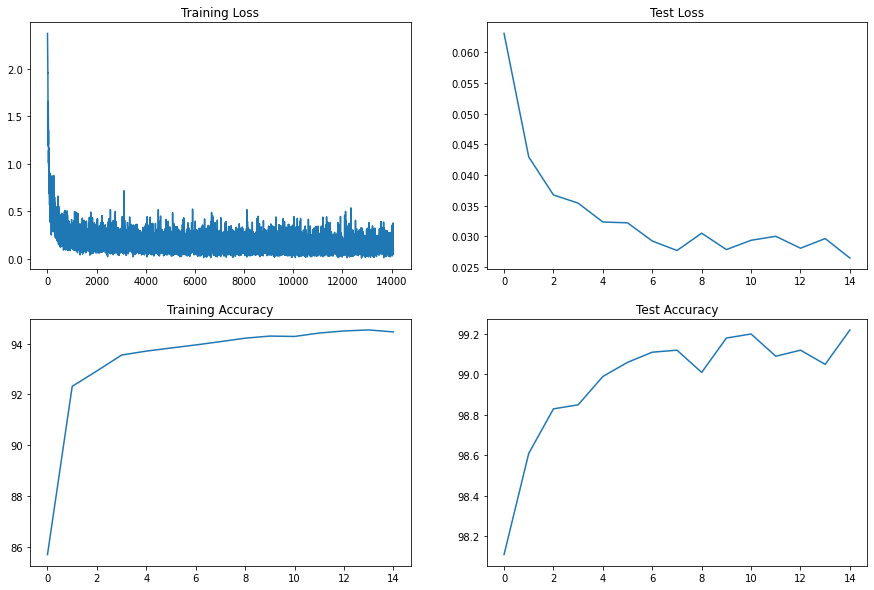

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_loss)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

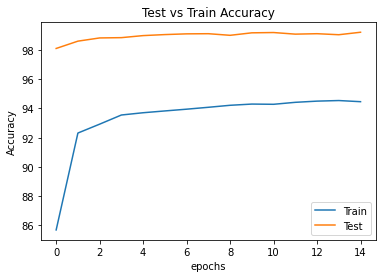

In [0]:
plt.axes(xlabel= 'epochs', ylabel= 'Accuracy')
plt.plot(train_acc)
plt.plot(test_acc)
plt.title('Test vs Train Accuracy')
plt.legend(['Train', 'Test'])

In [0]:
print(f'Max Training Loss {min(train_loss)} with Max Training Accuracy {max(train_acc)}\n')
print(f'Max Testing Loss {min(test_loss)} with Max Testing Accuracy {max(test_acc)}')

Max Training Loss 0.005630738567560911 with Max Training Accuracy 94.54333333333334

Max Testing Loss 0.02647799204289913 with Max Testing Accuracy 99.22


#Results:



1.   Parameters Used: **7408**
1.   Test Accuracy: **99.22%**
2.   Training Accuracy: **94.54%**
2.   Epochs Used: **15**



#Analysis:



1.   Over-fitting has been resolved, as we can inspect Train Accuracy is alwasys lesser than Test accuracy.
2.   But the test accuracy has decreased from 99.27 in previous iteration(with BatchNorm) to 99.22(with BatchNor+DropOut) 
3.   Number of Parameters used are 7408, so more 2500 parameters can be used if required.
4.   Need to improve effeciency.




